# Data Science Project Final Report
**By: Ricky Shi, Evan Chen, Mari Yasui, Shon Hoang**

---
# Introduction
### Data Description/Background


This project explores the player behavior using a dataset collected by a UBC Computer Science research group that ran a Minecraft server. As players joined and interacted with the world, the server recorded their individual information. This includes their age, name, gender, how many hours they played in total, their experience level, and whether they were subscribed to a game-related newsletter. 


This project uses two datasets, `players.csv` and `sessions.csv`, collected from a Minecraft research server operated by UBC’s Computer Science department. The data record player demographics and in-game activity. Our analysis will primarily use `players.csv`, as it includes both predictors and the response variable.

| Variable | Type | Description |
| --- | --- | --- |
| experience | factor | self-reported experience level (Amateur, Veteran, Regular, Behinner, Pro) |
| subscribe | logical | whether the player is subscribed to the newsletter |
| hashedEmail | character | a unique anonymized ID for each player |
| played_hours | numeric | total hours played by the player |
| name | character | the player's first name |
| gender | factor | the player's gender |
| Age | numeric | the player's age |

The variables *experience and gender* have been changed to categorical variables to better aid in further data-visualization, while *Age* has been changed to an integer variable.


| Dataset | Rows | Columns | Description |
|----------|------|----------|--------------|
| `players.csv` | 196 | 7 | Contains hashed emails (acts as player IDs) and variables such as age, gender, total playtime (hours), and newsletter subscription status |
| `sessions.csv` | 1535 | 5 | Contains session-level data, including hashed emails, start and end times, and timestamp equivalents |

**Potential Issues**
- Missing age for two players reduces usable data
- Extreme playtime values (e.g., idle sessions) may report inaccurate playtimes
- Subscription classes are imbalanced (many more “Yes” than “No”)
- Predictors use different scales and must be standardized

## Establishing the Question

**Broad Question:**  
What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do they differ between various player types?

**Specific Question:**  
The specific question we aim to answer using this dataset is: Can a player’s age and total playtime predict whether they subscribe to the game’s newsletter? 
The goal of this question is to see whether a player’s age and total number of played hours are useful indicators of whether they choose to subscribe to the game’s newsletter. 

To answer this question, we use the `players.csv` dataset, which contains a row per player and several columns that describe their characteristics. The variables/columns we focus on are:
<ul>
  <li>Subscribe (logical), which indicates whether the player is subscribed to the newsletter</li>
  <li>Age (numeric), which indicates the player’s age in years</li>
    <li>Played_hours (numeric), which indicates the total number of hours the player played on the server</li>
</ul>

In [1]:
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Methods and Results

In [10]:
# Load Data and summarize
players <- read_csv("https://github.com/FunkyMonkey245/dsci_project_planning_individual/raw/refs/heads/main/data/players.csv", show_col_types = FALSE)


players_summary <- players |>
    summarize(
        total_players = n(),
        subscribed_players = sum(subscribe == TRUE, na.rm = TRUE),
        unsubscribed_players = sum(subscribe == FALSE, na.rm = TRUE),
        subscribed_percent = round(100 * subscribed_players / total_players, 2),
        age_mean = round(mean(Age, na.rm = TRUE), 2),
        age_min  = min(Age, na.rm = TRUE),
        age_max  = max(Age, na.rm = TRUE),
        hours_mean = round(mean(played_hours, na.rm = TRUE), 2),
        hours_min  = min(played_hours, na.rm = TRUE),
        hours_max  = max(played_hours, na.rm = TRUE)
      )

glimpse(players)
players_summary

Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…


total_players,subscribed_players,unsubscribed_players,subscribed_percent,age_mean,age_min,age_max,hours_mean,hours_min,hours_max
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
196,144,52,73.47,21.14,9,58,5.85,0,223.1


**Summary Report: `players.csv`**

- Total players: 196
- Subscribed players: 144
- Unsubscribed players: 52
- Percent Subscribed: 73.47%
- Average player age: 21.14 years
- Youngest player: 9 years
- Oldest player: 58 years
- Average total playtime: 5.85 hours
- Lowest playtime: 0 Hours
- Highest playtime: 223.10 Hours

## Exploratory Data Analysis and Visualization

- For this section, we will use the `players.csv` dataset to summarize the mean of the predictor variables and visualize their relationships with newsletter subscription in multiple plots.
- Not much wrangling is needed as the dataset is already tidy for the analysis

In [3]:
# Mean summary of predictor variables
mean_summary <- players |>
    summarize(
        mean_age = round(mean(Age, na.rm = TRUE), 2),
        mean_playtime = round(mean(played_hours, na.rm = TRUE), 2),
      )

mean_summary

mean_age,mean_playtime
<dbl>,<dbl>
21.14,5.85


**Plots Included**
- Scatterplot of age vs. playtime colored by subscription
- Bar plot comparing subscription counts across experience levels
- Histograms showing playtime distribution for subscribers vs non-subscribers
- Log10 scaling was applied to playtime variables to compress extreme values and clearly show clustered data

**Observations**
- Most players recorded under 10 hours of total playtime
- There is a weak negative relationship between age and playtime, where younger players tend to play more
- Subscribed players generally show more total playtime
- Amateurs and veterans have the most subscribers

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `subscribe = fct_recode(subscribe, Yes = "TRUE", No = "FALSE")`.
Caused by warning:
! Unknown levels in `f`: TRUE, FALSE”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 85 rows containing non-finite outside the scale range (`stat_bin()`).”


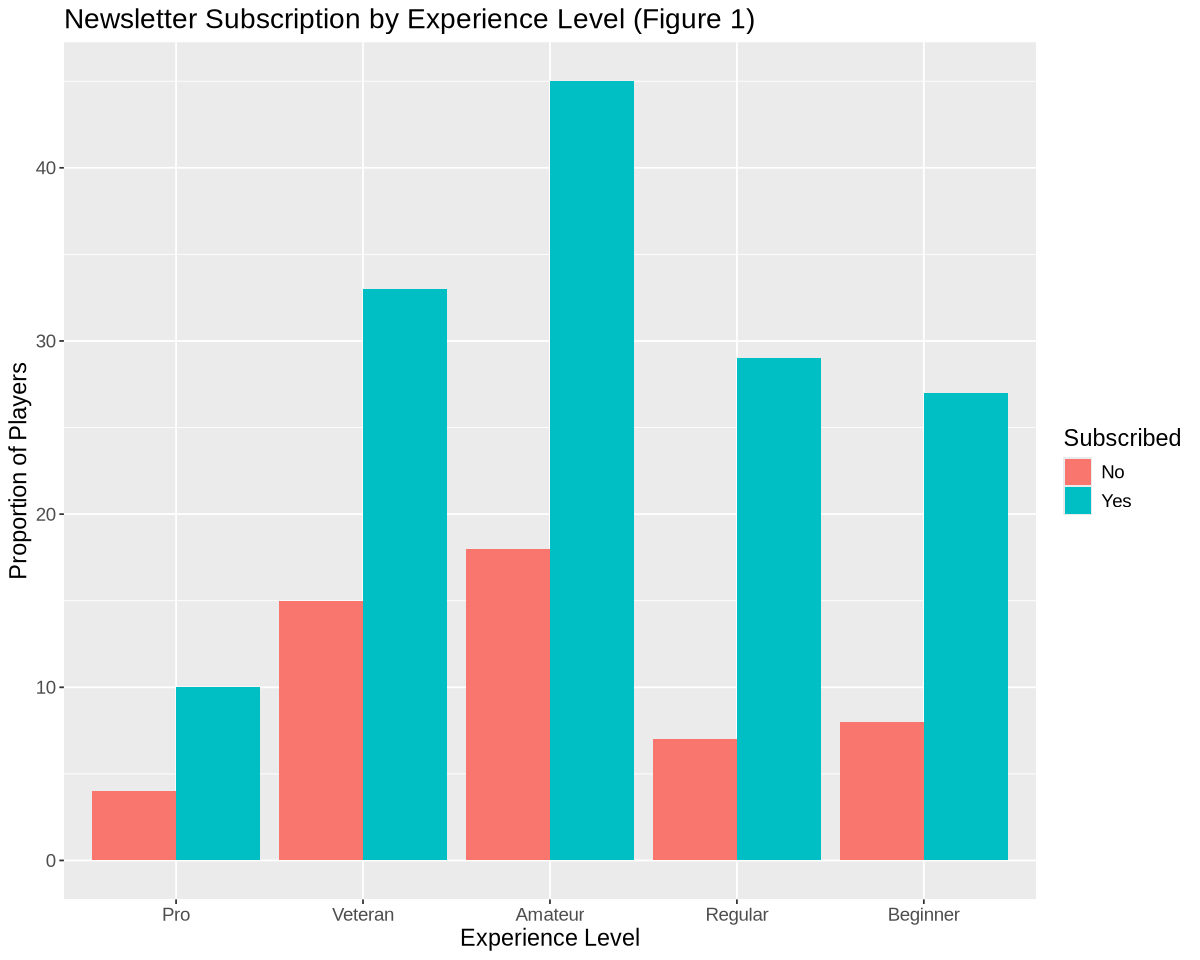

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


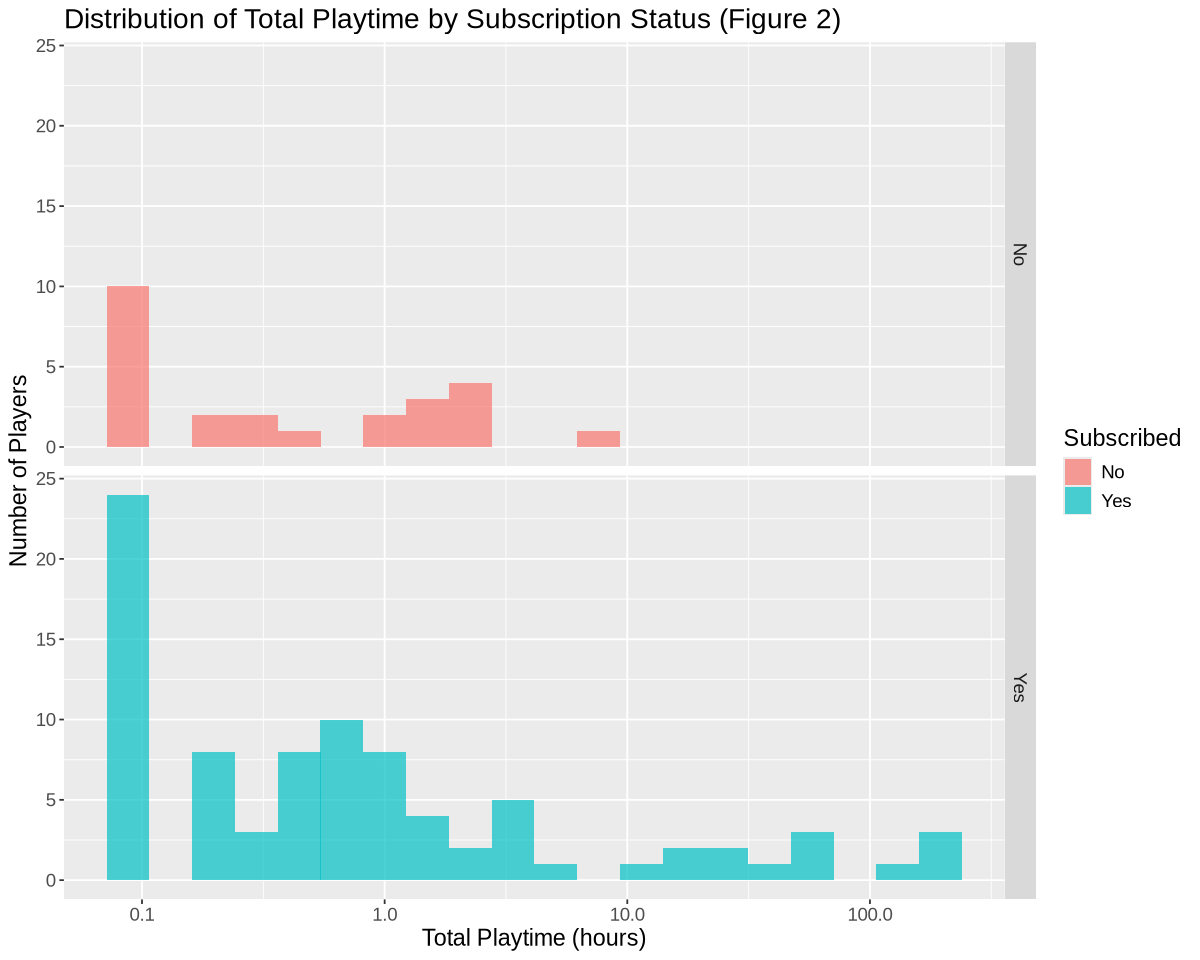

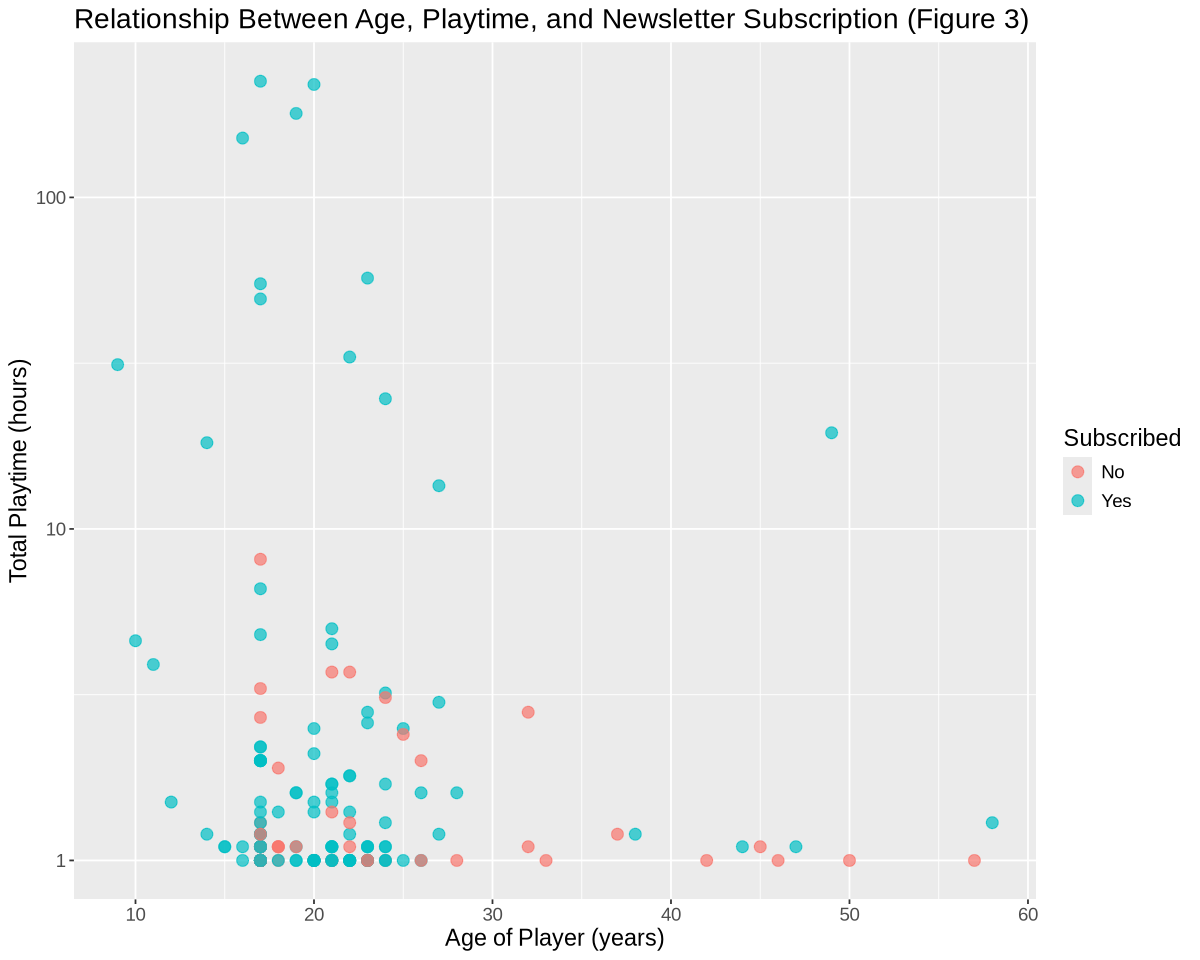

In [13]:
options(repr.plot.width = 10, repr.plot.height = 8)

#Data is already quite tidy, so changing the variable types is sufficient for my analysis

players <- players |>
    mutate(subscribe = as_factor(subscribe), subscribe = fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE"), experience = as_factor(experience))

# Plot visualizations showing the relationships between multiple variables in the players dataset

players_plot <- ggplot(players, aes(x = Age, y = played_hours + 1, color = subscribe)) +
    geom_point(alpha = 0.7, size = 3) +
    scale_y_log10() +
    labs(x = "Age of Player (years)", y = "Total Playtime (hours)", color = "Subscribed") +
    ggtitle("Relationship Between Age, Playtime, and Newsletter Subscription (Figure 3)") +
    theme(text = element_text(size = 14))

players_barplot <- ggplot(players, aes(x = experience, fill = subscribe)) +
    geom_bar(position = "dodge") +
    labs(title = "Newsletter Subscription by Experience Level (Figure 1)", x = "Experience Level", y = "Proportion of Players", fill = "Subscribed") +
    theme(text = element_text(size = 14))

players_histogram <- ggplot(players, aes(x = played_hours, fill = subscribe)) +
    geom_histogram(bins = 20, alpha = 0.7, position = "identity") +
    facet_grid(rows = vars(subscribe)) +
    scale_x_log10() +
    labs(title = "Distribution of Total Playtime by Subscription Status (Figure 2)", x = "Total Playtime (hours)", y = "Number of Players", fill = "Subscribed") +
    theme(text = element_text(size = 14))

players_barplot
players_histogram
players_plot 

## Data Analysis

The method we used to investigate our specific question was the K-nearest neighbours (KNN) classification model. We began by splitting the data into 70% training and 30% testing sets. Since KNN relies on distance calculations, we created a recipe for the predictors that centered and scaled both Age and played_hours so that they are on the same scale. 

Next, we defined a KNN model with the number of neighbours set to tune(). We then performed a 5-fold cross-validation on the training set to compare the different values of K, evaluating K values ranging from 1 to 50, and using accuracy to test the performance metric. For each value of K, we computed the mean accuracy across all 5 folds. 

Our results were then visualized using a line plot that showed accuracy vs K. The plot illustrates a clear increase in mean accuracy for values of K up until K=17, where the mean value levels off and stays constant. Since K=17 was the highest validation accuracy, it is the optimal number of neighbors for this model. 


## Finding K

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_impute_mean()
• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
17,accuracy,binary,0.7354497,5,0.005291005,Preprocessor1_Model17
19,accuracy,binary,0.7354497,5,0.005291005,Preprocessor1_Model19
21,accuracy,binary,0.7354497,5,0.005291005,Preprocessor1_Model21
22,accuracy,binary,0.7354497,5,0.005291005,Preprocessor1_Model22
23,accuracy,binary,0.7354497,5,0.005291005,Preprocessor1_Model23
24,accuracy,binary,0.7354497,5,0.005291005,Preprocessor1_Model24


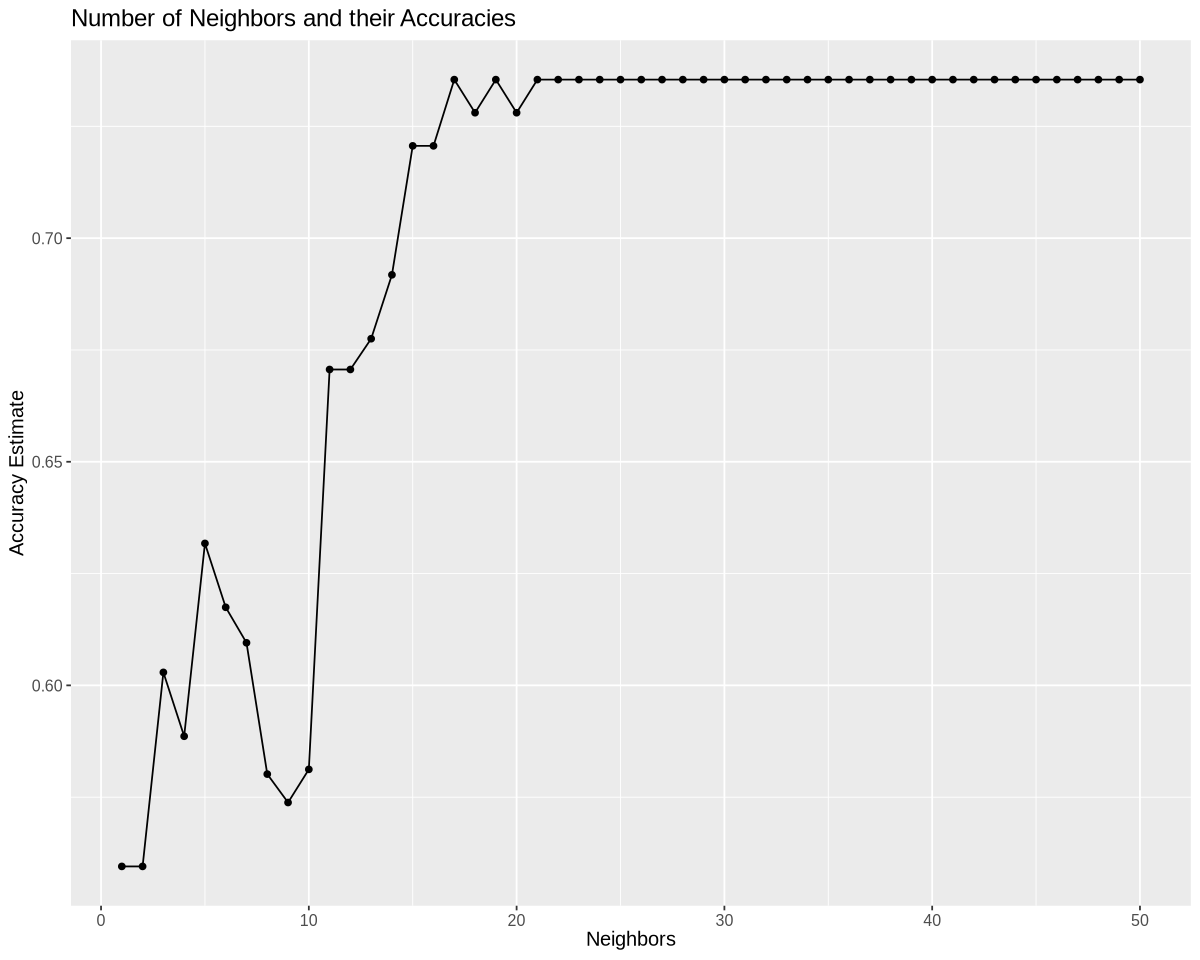

In [15]:
set.seed(2025)

players_split <- initial_split(players, prop = 0.70, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

players_recipe <- recipe(subscribe ~ Age + played_hours, data = players_train) |>
  step_impute_mean(all_predictors()) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

players_spec <- nearest_neighbor(weight_func = "rectangular",
                              neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

players_wkflw <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec)

players_wkflw

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_results <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec) |>
  tune_grid(resamples = players_vfold, grid = k_vals) |>
  collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")

highest_accuracy <- accuracies |>
  slice_max(mean, n = 1)

head(highest_accuracy)

Accuracy_graph <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "Number of Neighbors and their Accuracies") +
  theme(text = element_text(size = 12))

Accuracy_graph


In [14]:
players_spec <- nearest_neighbor(weight_func = "rectangular",
                              neighbors = 17) |>
  set_engine("kknn") |>
  set_mode("classification")

players_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec) |>
  fit(data = players_train)

players_fit

players_test_predictions <- predict(players_fit, players_test) |>
	bind_cols(players_test) |>	
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

players_test_predictions

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_impute_mean()
• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(17,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2573529
Best kernel: rectangular
Best k: 17

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7666667
